In [2]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import inspect
import textwrap

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set

import torch.nn.functional as F

In [4]:
def f(t,x,w):
    #write the function that is on the other side of the differential equation
    return -w*x

def differential_equation_1_order(t, x, w):
    dx_dt = f(t,x,w)
    return dx_dt

def differential_equation_2_order(t, X, w):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,w)

    return [dx_dt, dy_dt]

In [5]:
cooling_deq = diffeq(differential_equation_2_order, 2, 1)

train, test = create_trainig_test_set(cooling_deq, (0, 10), 100, 1000, 0.3, "RK45")
print(train["X"][0].shape)

torch.Size([103])


In [6]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

In [40]:
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.linear = nn.Linear(in_features=n_step, out_features=200)
        self.linear2 = nn.Linear(200, 100)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return x

# Initiate the model
model = CoolingModel(103)

In [41]:
loss_func = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

In [42]:
epochs = 10000

for epoch in range(epochs):
    T_pred = model(train["X"])
    
    loss = loss_func(T_pred, train["y_tensor"][0:, 0])

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/10)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1000/10000, Loss: 0.7131
Epoch 2000/10000, Loss: 0.6019
Epoch 3000/10000, Loss: 0.5443
Epoch 4000/10000, Loss: 0.5069
Epoch 5000/10000, Loss: 0.4738
Epoch 6000/10000, Loss: 0.4418
Epoch 7000/10000, Loss: 0.4122
Epoch 8000/10000, Loss: 0.3853
Epoch 9000/10000, Loss: 0.3617
Epoch 10000/10000, Loss: 0.3400


In [43]:
model.eval()
with torch.no_grad():
    T_pred_test = model(test["X"])
    print(T_pred_test)
    test_loss = loss_func(T_pred_test, test["y_tensor"][0:, 0])
    print(f"Test Loss: {test_loss.item():.4f}")

tensor([[0.3831, 0.3710, 0.5362,  ..., 0.1991, 0.2283, 0.1544],
        [0.4953, 0.7239, 0.6502,  ..., 0.2013, 0.1940, 0.2134],
        [0.6734, 0.7516, 0.8121,  ..., 0.1700, 0.1730, 0.1838],
        ...,
        [0.4012, 0.4404, 0.4813,  ..., 0.1618, 0.1682, 0.2133],
        [0.4822, 0.5500, 0.5844,  ..., 0.1507, 0.1579, 0.1914],
        [0.2967, 0.3455, 0.3441,  ..., 0.2200, 0.2168, 0.2747]])
Test Loss: 0.4519


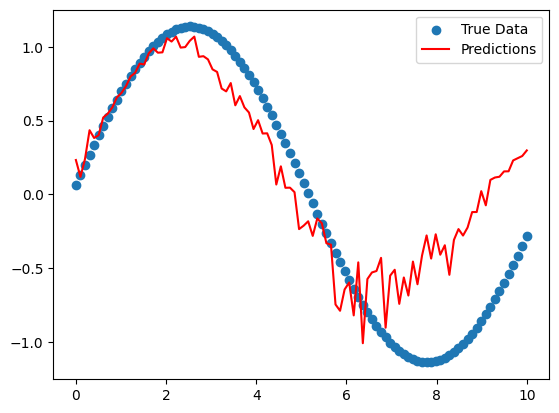

In [53]:
n = 8
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0], label="True Data")
plt.plot(test["t_tensor"][n], T_pred_test[n], color="red", label="Predictions")
plt.legend()
plt.show()